In [375]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier 
from IPython.display import display
import pickle
#import kagglehub

In [394]:
df = pd.read_csv('Dataset.csv', sep=';')
df.info()
#df[df['Did you seek any specialist for a treatment?']=='Yes']
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   warehouse_block      10999 non-null  object
 1   mode_of_shipment     10999 non-null  object
 2   customer_care_calls  10999 non-null  int64 
 3   customer_rating      10999 non-null  int64 
 4   cost_of_the_product  10999 non-null  int64 
 5   prior_purchases      10999 non-null  int64 
 6   product_importance   10999 non-null  object
 7   discount offered     10999 non-null  int64 
 8   weight               10999 non-null  int64 
 9   on_time_delivery     10999 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 859.4+ KB


,warehouse_block,mode_of_shipment,customer_care_calls,customer_rating,cost_of_the_product,prior_purchases,product_importance,discount offered,weight,on_time_delivery
0,D,Flight,4,2,177,3,low,44,1233,1
1,F,Flight,4,5,216,2,low,59,3088,1
2,A,Flight,2,2,183,4,low,48,3374,1
3,B,Flight,3,3,176,4,medium,10,1177,1
4,C,Flight,2,2,184,3,medium,46,2484,1


**Data Preparation**

In [395]:
df.columns = df.columns.str.lower().str.replace(' ','_')
print(df.columns)

print()
print('customer rating ', list(df['customer_rating'].unique()))

print()

df = df.copy()
for i in range(0, df.shape[0]):
    
    if df['customer_rating'][i] == 5:
        df.loc[i, 'customer_rating'] = 'very_high'
    
    elif df['customer_rating'][i] == 4:
        df.loc[i, 'customer_rating'] = 'high'
    
    elif df['customer_rating'][i] == 3:
        df.loc[i, 'customer_rating'] = 'medium'
    
    elif df['customer_rating'][i] == 2:
        df.loc[i, 'customer_rating'] = 'low'
    
    elif df['customer_rating'][i] == 1:
        df.loc[i, 'customer_rating'] = 'very_low'

print()


print('customer rating after transition', list(df['customer_rating'].unique()))



Index(['warehouse_block', 'mode_of_shipment', 'customer_care_calls',
       'customer_rating', 'cost_of_the_product', 'prior_purchases',
       'product_importance', 'discount_offered', 'weight', 'on_time_delivery'],
      dtype='object')

customer rating  [2, 5, 3, 1, 4]



C:\Users\musta\AppData\Local\Temp\ipykernel_10324\1418634193.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'low' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'customer_rating'] = 'low'



customer rating after transition ['low', 'very_high', 'medium', 'very_low', 'high']


In [396]:
print(df.dtypes)
categorical = (['warehouse_block', 'mode_of_shipment',
               'customer_rating', 'product_importance'])
numerical = (['customer_care_calls', 'cost_of_the_product',
              'prior_purchases', 'discount_offered', 'weight'])

print()
for c in categorical:
    print('Feature: ', c)
    print(df[c].unique())
    print(df[c].describe())
    print()

warehouse_block        object
mode_of_shipment       object
customer_care_calls     int64
customer_rating        object
cost_of_the_product     int64
prior_purchases         int64
product_importance     object
discount_offered        int64
weight                  int64
on_time_delivery        int64
dtype: object

Feature:  warehouse_block
['D' 'F' 'A' 'B' 'C']
count     10999
unique        5
top           F
freq       3666
Name: warehouse_block, dtype: object

Feature:  mode_of_shipment
['Flight' 'Ship' 'Road']
count     10999
unique        3
top        Ship
freq       7462
Name: mode_of_shipment, dtype: object

Feature:  customer_rating
['low' 'very_high' 'medium' 'very_low' 'high']
count      10999
unique         5
top       medium
freq        2239
Name: customer_rating, dtype: object

Feature:  product_importance
['low' 'medium' 'high']
count     10999
unique        3
top         low
freq       5297
Name: product_importance, dtype: object



In [397]:
df.isnull().sum()

warehouse_block        0
mode_of_shipment       0
customer_care_calls    0
customer_rating        0
cost_of_the_product    0
prior_purchases        0
product_importance     0
discount_offered       0
weight                 0
on_time_delivery       0
dtype: int64

In [398]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_full_train = df_full_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_full_train = df_full_train['on_time_delivery'].values
x_full_train = df_full_train[numerical + categorical]
df_train, df_val, y_train, y_val = train_test_split(x_full_train, y_full_train, test_size=0.25, random_state=42)
df_test_x = df_test[numerical + categorical]
y_test = df_test['on_time_delivery'].values

In [399]:
print(df_full_train.shape, df_train.shape, df_val.shape, df_test_x.shape, len(y_train), len(y_val), len(y_test))

(8799, 10) (6599, 9) (2200, 9) (2200, 9) 6599 2200 2200


**EDA and Feature Importance**

Total number of orders:  10999
number of orders delivered on time:  6563
Proportion of orders delivered on time:  0.597


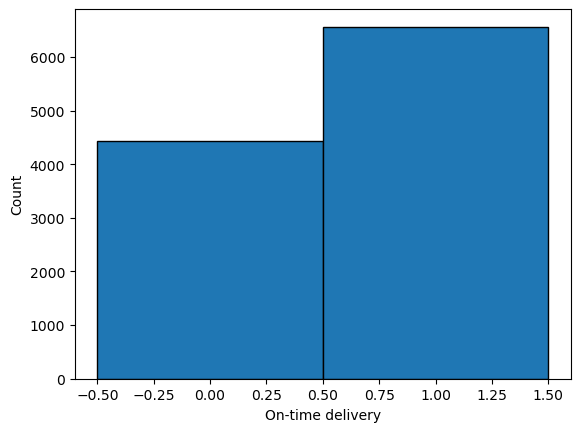

In [400]:
print('Total number of orders: ', df['on_time_delivery'].shape[0])
print('number of orders delivered on time: ', df['on_time_delivery'].value_counts()[1])
print('Proportion of orders delivered on time: ', df['on_time_delivery'].mean().round(3))

labels= np.array([0,1])
values= np.array([df['on_time_delivery'].value_counts()[0], df['on_time_delivery'].value_counts()[1]])
plt.bar(labels, values, width=1,edgecolor='black')
plt.xlabel("On-time delivery")
plt.ylabel("Count")
plt.show()

In [401]:
for c in categorical:
    print('Feature: ', c)
    print('  categories: ', df[c].unique())
    print()
print()

print('Proportions of orders delivered on time per category for each feature:')
print()

for c in categorical:
    print(f'for the feature {c}')
    for x in  df[c].unique():
        print(x, df['on_time_delivery'][df[c]==x].mean().round(3))
    print()

Feature:  warehouse_block
  categories:  ['D' 'F' 'A' 'B' 'C']

Feature:  mode_of_shipment
  categories:  ['Flight' 'Ship' 'Road']

Feature:  customer_rating
  categories:  ['low' 'very_high' 'medium' 'very_low' 'high']

Feature:  product_importance
  categories:  ['low' 'medium' 'high']


Proportions of orders delivered on time per category for each feature:

for the feature warehouse_block
D 0.598
F 0.598
A 0.586
B 0.602
C 0.597

for the feature mode_of_shipment
Flight 0.602
Ship 0.598
Road 0.588

for the feature customer_rating
low 0.588
very_high 0.607
medium 0.606
very_low 0.587
high 0.595

for the feature product_importance
low 0.593
medium 0.59
high 0.65



In [402]:
print('Correlation between numerical features and on_time_delivery rate')
print(df_full_train[numerical].corrwith(df_full_train['on_time_delivery']))
print()
def mutual_info(series):
    return mutual_info_score(series, df_full_train['on_time_delivery'])

mi = df_full_train[categorical].apply(mutual_info)

print('Mutual Feature Information:')
print(mi)

Correlation between numerical features and on_time_delivery rate
customer_care_calls   -0.072117
cost_of_the_product   -0.078052
prior_purchases       -0.060074
discount_offered       0.396499
weight                -0.264249
dtype: float64

Mutual Feature Information:
warehouse_block       0.000182
mode_of_shipment      0.000045
customer_rating       0.000283
product_importance    0.000649
dtype: float64


**OneHotEncoding**

In [403]:
dict_train = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse= False)
x_train = dv.fit_transform(dict_train)
print(dv.get_feature_names_out(dict_train))
x_train[0]

['cost_of_the_product' 'customer_care_calls' 'customer_rating=high'
 'customer_rating=low' 'customer_rating=medium'
 'customer_rating=very_high' 'customer_rating=very_low' 'discount_offered'
 'mode_of_shipment=Flight' 'mode_of_shipment=Road' 'mode_of_shipment=Ship'
 'prior_purchases' 'product_importance=high' 'product_importance=low'
 'product_importance=medium' 'warehouse_block=A' 'warehouse_block=B'
 'warehouse_block=C' 'warehouse_block=D' 'warehouse_block=F' 'weight']


array([2.190e+02, 6.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       1.000e+00, 1.000e+01, 0.000e+00, 1.000e+00, 0.000e+00, 6.000e+00,
       0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00, 2.385e+03])

**Model Training**

In [404]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)

#for c in categorical:
#    cat = categorical.copy()
#    cat.remove(c)


LogisticRegression(max_iter=10000)

In [406]:
dict_val = df_val.to_dict(orient='records')
x_val = dv.transform(dict_val)
y_pred = model.predict_proba(x_val)[:,1]
print(y_pred)
delivered_on_time = (y_pred >= 0.5).astype(int)
accuracy = (y_val==delivered_on_time).mean().round(3)
print(accuracy)

[0.74849507 0.87726209 0.58237637 ... 0.36555309 0.99149312 0.39717267]
0.617


**Since no clear assumptions regarding Feature Importance from MI and Feature Correlation could be made, the Accuracy is to be calculated for different compinations of features removing**

In [407]:
for c in categorical:
    col = list(df_train.columns)
    col.remove(c)

    dict_train = df_train[col].to_dict(orient='records')
    dv = DictVectorizer(sparse= False)
    x_train = dv.fit_transform(dict_train)
    
    model = LogisticRegression(solver='liblinear', C=100, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    
    dict_val = df_val[col].to_dict(orient='records')
    x_val = dv.transform(dict_val)
    y_pred = model.predict_proba(x_val)[:,1]
    
    
    delivery_on_time = y_pred >=0.5
    accuracy = (delivery_on_time == y_val).mean().round(3)
    diff = (0.613 - accuracy).round(4)

    print(f'features excluded: {c}, // new accuracy: {accuracy} // difference in accuracy: {diff}')
    print()

features excluded: warehouse_block, // new accuracy: 0.614 // difference in accuracy: -0.001

features excluded: mode_of_shipment, // new accuracy: 0.615 // difference in accuracy: -0.002

features excluded: customer_rating, // new accuracy: 0.61 // difference in accuracy: 0.003

features excluded: product_importance, // new accuracy: 0.611 // difference in accuracy: 0.002



In [408]:
col = list(df_train.columns)
for n in numerical:
    col.remove(n)

    dict_train = df_train[col].to_dict(orient='records')
    dv = DictVectorizer(sparse= False)
    x_train = dv.fit_transform(dict_train)
    
    model = LogisticRegression(solver='liblinear', C=100, max_iter=1000, random_state=42)
    model.fit(x_train, y_train)
    
    dict_val = df_val[col].to_dict(orient='records')
    x_val = dv.transform(dict_val)
    y_pred = model.predict_proba(x_val)[:,1]
    
    
    delivery_on_time = y_pred >=0.5
    accuracy = (delivery_on_time == y_val).mean().round(3)
    diff = (0.613 - accuracy).round(4)

    print(f'features excluded: , {n} // new accuracy: {accuracy} // difference in accuracy: {diff}')
    print()

features excluded: , customer_care_calls // new accuracy: 0.611 // difference in accuracy: 0.002

features excluded: , cost_of_the_product // new accuracy: 0.606 // difference in accuracy: 0.007

features excluded: , prior_purchases // new accuracy: 0.604 // difference in accuracy: 0.009

features excluded: , discount_offered // new accuracy: 0.62 // difference in accuracy: -0.007

features excluded: , weight // new accuracy: 0.593 // difference in accuracy: 0.02



**All Accuracies obtained after removing different features were close to the Accuracy calculated with all features included.** 

**   **

**Trying Different Models and Evaluation**

In [409]:
dict_train = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse= False)
x_train = dv.fit_transform(dict_train)

model = LogisticRegression(solver='liblinear', max_iter=10000)
model.fit(x_train, y_train)

dict_val = df_val.to_dict(orient='records')
x_val = dv.transform(dict_val)

y_pred_lr = model.predict_proba(x_val)[:,1]

auc_lr = roc_auc_score(y_val, y_pred_lr)
print(f"Logistic Regeression AUC: {auc_lr: .4f}")

Logistic Regeression AUC:  0.6920


In [410]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(x_train, y_train)

y_pred_rf = rf.predict_proba(x_val)[:, 1]

auc_rf = roc_auc_score(y_val, y_pred_rf)
print(f"Random Forest AUC: {auc_rf: .4f}")

Random Forest AUC:  0.7283


In [411]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(x_train, y_train)

y_pred_dt = dt.predict_proba(x_val)[:, 1]

auc_dt = roc_auc_score(y_val, y_pred_dt)
print(f"Decision Tree AUC: {auc_dt: .4f}")

Decision Tree AUC:  0.7139


In [412]:
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric = 'logloss')
xgb.fit(x_train, y_train)

y_pred_xgb = xgb.predict_proba(x_val)[:, 1]

auc_xgb = roc_auc_score(y_val, y_pred_xgb)
print(f"XGBoost AUC: {auc_xgb: .4f}")

C:\Users\musta\anaconda3\Lib\site-packages\xgboost\training.py:199: UserWarning: [20:16:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC:  0.7217


**The best Model is Random Forest Classifier**

In [413]:
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 15, 20],
    'min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid_search.fit(x_train, y_train)
print(grid_search.best_params_)
print(f"Best AUC is: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
{'max_depth': 10, 'min_samples_leaf': 10, 'n_estimators': 100}
Best AUC is: 0.7458


In [392]:
dict_x_full = df_full_train[categorical + numerical].to_dict(orient='records')
x_full = dv.fit_transform(dict_x_full)

final_model = RandomForestClassifier(
    n_estimators=100,
    min_samples_leaf=10, 
    max_depth=10, 
    n_jobs=-1,
    random_state=42
)


final_model.fit(x_full, y_full_train)



RandomForestClassifier(max_depth=10, min_samples_leaf=10, n_jobs=-1,
                       random_state=42)

In [414]:
x_test_dict = df_test_x.to_dict(orient='records')
x_test = dv.transform(x_test_dict)

y_pred = final_model.predict_proba(x_test)[:, 1]

auc_final = roc_auc_score(y_test, y_pred)
print(f"Final Model AUC : {auc_final:.4f}")

Final Model AUC : 0.7485
